In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.diagnostic as diag
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, RepeatedKFold, cross_validate, cross_val_score
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from scipy.stats import normaltest
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer


np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [ ]:
# Global Variables
seed = random.seed(123)
number_clusters = 3

# Analisis Exploratorio

In [ ]:
# Variable classification
train_data = pd.read_csv('./data/train.csv', encoding = "ISO-8859-1")
test_data = pd.read_csv('./data/test.csv', encoding = "ISO-8859-1")
variables = pd.read_csv('./data/variables.txt', encoding = "ISO-8859-1")
quant_vars = list(variables.loc[(variables['Clasification'] == 'Cuantitativa')]['Variable'].values)
quali_vars = list(variables.loc[(variables['Clasification'] == 'Cualitativa')]['Variable'].values)[1:]

### Analizando las variables numericas

In [ ]:
train_data[quant_vars].describe()

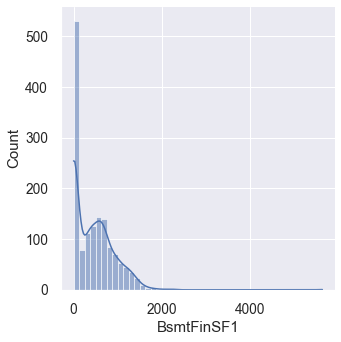

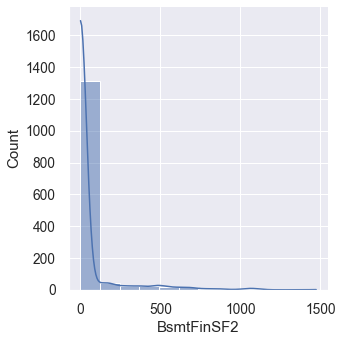

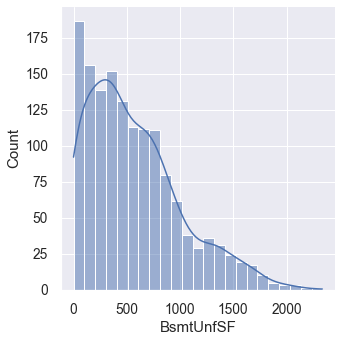

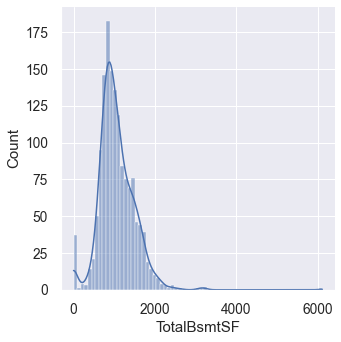

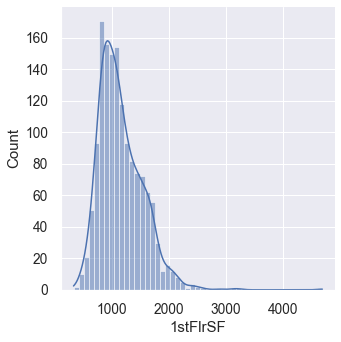

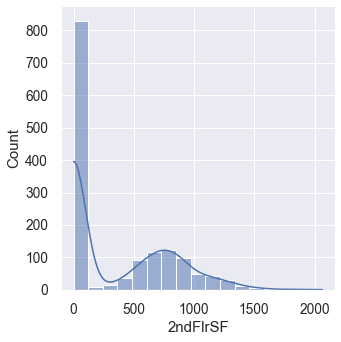

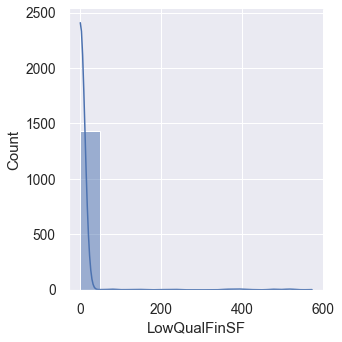

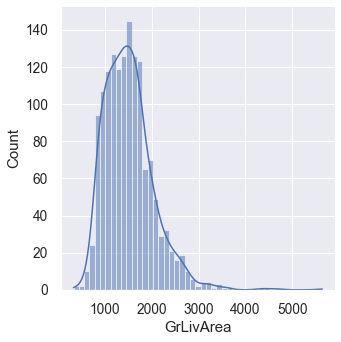

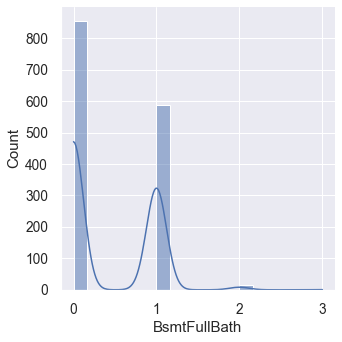

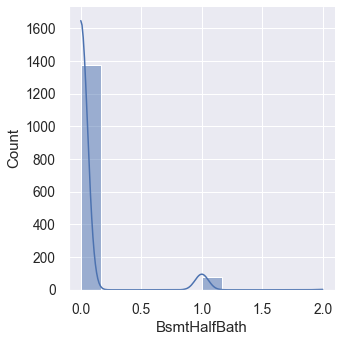

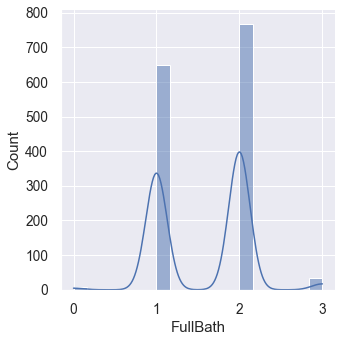

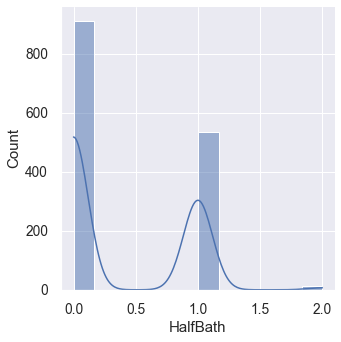

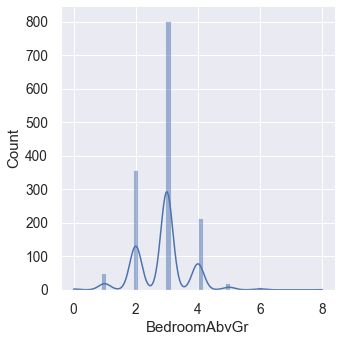

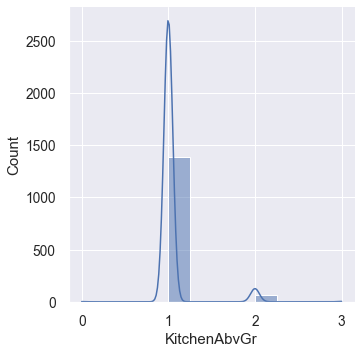

In [22]:
for var in quant_vars:
    data = train_data[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)

    # Mostrando normalidad
    print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(data), 'Skewness:', stats.skew(data), '\n')

### Analizando las variables categoricas

In [ ]:
for var in quali_vars:
  plt.figure(figsize=(20,5))
  train_data[var].value_counts().plot(kind='bar')
  plt.show()

### Analizando la variable de interes

In [ ]:
#skewness and kurtosis
print('Skewness: %f' % train_data['SalePrice'].skew())
print('Kurtosis: %f' % train_data['SalePrice'].kurt())
print('\n---Describe---')
train_data['SalePrice'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 0.95])

In [ ]:
stat,p = stats.shapiro(train_data[["SalePrice"]].dropna())
print('Kolmogorov-Smirnov:\np=%f\n'% p)
ks_statistic, p_value = diag.lilliefors(train_data[["SalePrice"]].dropna())
print('Lilliefors:\nks=%f\np=%f'%(ks_statistic,p_value))

In [ ]:
sns.displot(train_data['SalePrice'], kde=True)

### Correlacion

In [ ]:
k = 10 #number of variables for heatmap
corrmat = train_data.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Obteniendo la relacion entre las variables mas significativas

In [ ]:
sns.pairplot(train_data[cols],hue="SalePrice")
plt.show()
# quant_vars

# Analizando data

In [ ]:
def categorize(row): 
    if row['SalePrice'] > 0 and row['SalePrice'] <= 179280:
        return 'Low'
    elif row['SalePrice'] > 179280 and row['SalePrice'] < 326100:
        return 'Medium'
    else:
        return 'Expensive'
   
train_data['SalesCategories'] = train_data.apply(lambda row: categorize(row), axis=1)


train_data

# Preprocesamiento

In [ ]:
copied_train_data = train_data.copy()
copied_train_data = copied_train_data.fillna(0)

target = copied_train_data.pop('SalesCategories')
data = copied_train_data

In [ ]:
categoricas = copied_train_data[quali_vars]
numericas = copied_train_data[quant_vars]

In [ ]:
#Se transforman las colunas usando los preprocesadores
numeric_preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Se preparan los preprocesadores
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")


preprocesador = ColumnTransformer([
    ('one_hot_encoder', categorical_preprocessor, quali_vars),
    ('numerico', numeric_preprocessor, quant_vars)
],remainder="passthrough")

70% de entrenamiento y 30% prueba

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(data, target,test_size=0.3,train_size=0.7)

In [ ]:
X_train

## Creando el modelo

In [ ]:
modelo = make_pipeline(preprocesador, SVC(kernel="linear"))

# Esto nos permite ver dentro del modelo
set_config(display='diagram')
modelo

In [ ]:
modelo.fit(X_train,y_train)

#### Resultados esperados

In [ ]:
target_pred = modelo.predict(X_test)
print(target_pred)
print ("Accuracy:",metrics.accuracy_score(y_test, target_pred))
print ("Precision:", metrics.precision_score(y_test,target_pred,average='weighted') )
print ("Recall: ", metrics.recall_score(y_test,target_pred,average='weighted'))

In [ ]:
# evaluate on the train dataset
cross_validate(logReg, X_train, y_train, return_train_score=True)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(logReg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

## Grafica

In [ ]:
sns.regplot(x=X_test["SalePrice"], y=y_pred, data=train_data, logistic=True, ci=None)

### Tunning

In [ ]:
# Ridge application
clf = Ridge(alpha = 1.0)
clf.fit(X_train,y_train)
y_tunning_pred = clf.predict(X_test)
clf.score(X_train,y_train)

In [ ]:
# Evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# Force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))